# Análise do Portfolio de Fundos

### Inicializações

In [39]:
import pandas as pd
import numpy as np

from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("whitegrid")


In [40]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')
exchange_rates.head()

,USD2EUR
Date,
2022-12-04,0.94860
2022-12-03,0.94902
2022-12-02,0.94908
2022-12-01,0.94991
2022-11-30,0.95935


In [41]:
#Get the Portofolio
portfolio_csv = 'portofolio.csv'
df_portofolio = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
code2name_dict = {x[0]:x[1] for x in df_portofolio.itertuples()}
df_portofolio.sort_values(by="Nome", axis=0)

,Nome,Moeda,Quantidade
Code,,,
LU0524465977,Alken European Opport A,EUR,8.53679
LU1883314244,Amundi Europ Value A C,EUR,7.35600
LU0171309270,BGF Healthscience E2 EUR,EUR,103.70000
LU0823417141,BNP Health Care In\tN Capit,EUR,13.08300
LU0815616999,BTG SICAV Latin American Eq A,USD,208.76800
LU0108459040,Candriam Biotech C Cap USD,USD,7.83800
LU1769942746,DWS CROCI US Divid,USD,18.47000
LU2210151697,FF Abs Ret Gb Eq,USD,592.20000
LU0197230542,Fidelity India Focus A,EUR,26.76000


In [42]:
#Get the historical quotes 

xls = 'historico_cotacoes.xlsx'
dict_df = pd.read_excel(xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date'], infer_datetime_format = True).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df = df_all.dropna()

#Create a DataFrame with the daily growth
df_grow = df.apply(lambda x: x/x.shift(-1), axis=0).dropna()

df_all.head()

,LU0094557526,LU0171309270,LU0248173006,PTSQUGHM0007,LU0384381660,LU0823417141,LU1769942746,LU2210151697,IE00BD3B6K23,LU0108459040,...,LU0269905138,LU0524465977,LU0815616999,LU1670707956,IE0002167009,LU0248185513,LU0197230542,LU0122613903,LU1883314244,LU1897414303
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-05,NaN,NaN,39.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.05,NaN,NaN,10.99,NaN,187.06,NaN,NaN,NaN,18.06
2022-12-02,45.26,55.44,38.88,10.75,66.44,421.09,324.44,10.71,106.81,810.16,...,15.83,238.75,9.38,10.94,15.30,187.69,75.24,8.42,137.18,17.98
2022-12-01,45.27,55.62,39.20,NaN,67.82,419.62,328.66,10.69,106.74,797.62,...,16.01,239.20,9.41,10.91,15.40,191.18,75.72,8.44,137.08,17.96
2022-11-30,45.33,55.03,38.91,10.74,65.97,423.36,320.05,10.70,106.65,794.81,...,15.87,237.37,9.40,10.81,15.29,187.57,76.42,8.43,136.23,17.68
2022-11-29,44.51,54.94,38.34,10.74,65.20,408.76,322.43,10.74,106.84,766.31,...,15.61,235.43,9.20,10.73,14.49,188.18,75.39,8.36,135.93,17.26


In [43]:
# Calculate the Portofolio Std and Growth
df_portofolio['STD'] = df_grow.std(axis=0)
df_portofolio['Growth'] = df.apply(lambda x: x[0]/x[-1]-1)
df_portofolio['Racio'] = df_portofolio['Growth']/df_portofolio['STD']

In [44]:
# Get the Current Total Amount in EUR

last_date = min(df_all.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date][0]
# Get the last Quotes
quotes = df_all.fillna(method='bfill').iloc[0]

df_portofolio['Amount EUR'] = df_portofolio['Moeda'].apply(lambda x: usd2eur if x == 'USD' else 1) * quotes * df_portofolio['Quantidade']

sum(df_portofolio['Amount EUR'])

128088.92109273601

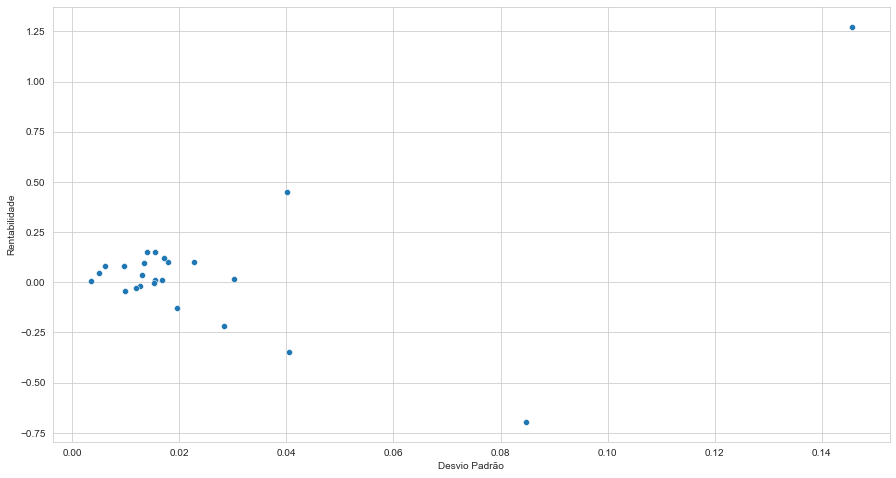

In [45]:
plt.figure(figsize=(15,8))
plt.xlabel('Desvio Padrão')
plt.ylabel('Rentabilidade')
p = sn.scatterplot(x=df_portofolio['STD'],y=df_portofolio['Growth'])

In [46]:
df_portofolio.sort_values(by=['Nome'],ascending=True)

,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
LU0524465977,Alken European Opport A,EUR,8.53679,0.015420,0.148389,9.623337,2038.158612
LU1883314244,Amundi Europ Value A C,EUR,7.35600,0.015237,-0.001819,-0.119387,1009.096080
LU0171309270,BGF Healthscience E2 EUR,EUR,103.70000,0.017851,0.101311,5.675483,5749.128000
LU0823417141,BNP Health Care In\tN Capit,EUR,13.08300,0.017098,0.121680,7.116463,5509.120470
LU0815616999,BTG SICAV Latin American Eq A,USD,208.76800,0.013951,0.152334,10.919314,1857.590107
LU0108459040,Candriam Biotech C Cap USD,USD,7.83800,0.022682,0.101359,4.468702,6023.642328
LU1769942746,DWS CROCI US Divid,USD,18.47000,0.013453,0.095785,7.120152,5684.397090
LU2210151697,FF Abs Ret Gb Eq,USD,592.20000,0.009609,0.080727,8.400819,6016.459453
LU0197230542,Fidelity India Focus A,EUR,26.76000,0.015535,0.013197,0.849505,2013.422400


In [47]:
df_portofolio['Amount EUR'].sum()

128088.92109273601

In [48]:
df_portofolio = df_portofolio[df_portofolio.index != "LU0122613903"]

c:\MyPrograms\miniconda3\envs\fundos\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\MyPrograms\miniconda3\envs\fundos\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 1080x576 with 0 Axes>

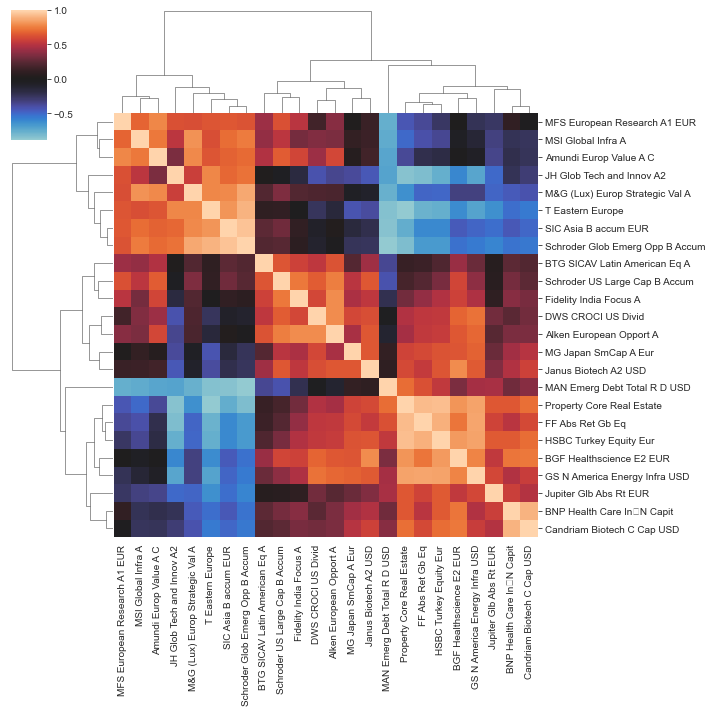

In [49]:
plt.figure(figsize=(15,8))
sn.clustermap(df_grow.rename(columns=code2name_dict).corr(),center=0)
#df_grow.corr()

In [62]:
##### Performance in the last days
df_portofolio_tmp = df_portofolio.copy()
start =5
finish = 0
print('Start Date:',df_all.index[start])
df_portofolio_tmp['Growth'] = df_all.fillna(method='bfill').fillna(method='pad').apply(lambda x: x[finish]/x[start]-1)
df_portofolio_tmp['Racio'] = df_portofolio_tmp['Growth']/df_portofolio_tmp['STD']
df_portofolio_tmp.sort_values(by=['Racio'],ascending=False)

Start Date: 2022-11-28


,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
LU0248173006,SIC Asia B accum EUR,EUR,104.95000,0.019522,0.067568,3.461038,4145.525000
LU0815616999,BTG SICAV Latin American Eq A,USD,208.76800,0.013951,0.041065,2.943574,1857.590107
LU0108459040,Candriam Biotech C Cap USD,USD,7.83800,0.022682,0.053442,2.356127,6023.642328
LU0823417141,BNP Health Care In\tN Capit,EUR,13.08300,0.017098,0.031376,1.834995,5509.120470
LU0269905138,Schroder Glob Emerg Opp B Accum,USD,490.42000,0.028370,0.046284,1.631441,7466.659213
LU0094557526,MFS European Research A1 EUR,EUR,152.79100,0.009856,0.015709,1.593902,6915.320660
LU0524465977,Alken European Opport A,EUR,8.53679,0.015420,0.018906,1.226082,2038.158612
LU1670707956,M&G (Lux) Europ Strategic Val A,USD,965.57600,0.016762,0.020427,1.218672,10066.239876
IE0002167009,JH Glob Tech and Innov A2,EUR,134.04800,0.040535,0.047945,1.182811,2050.934400


Start Date: 2022-11-28


<AxesSubplot:xlabel='Date'>

c:\MyPrograms\miniconda3\envs\fundos\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\MyPrograms\miniconda3\envs\fundos\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


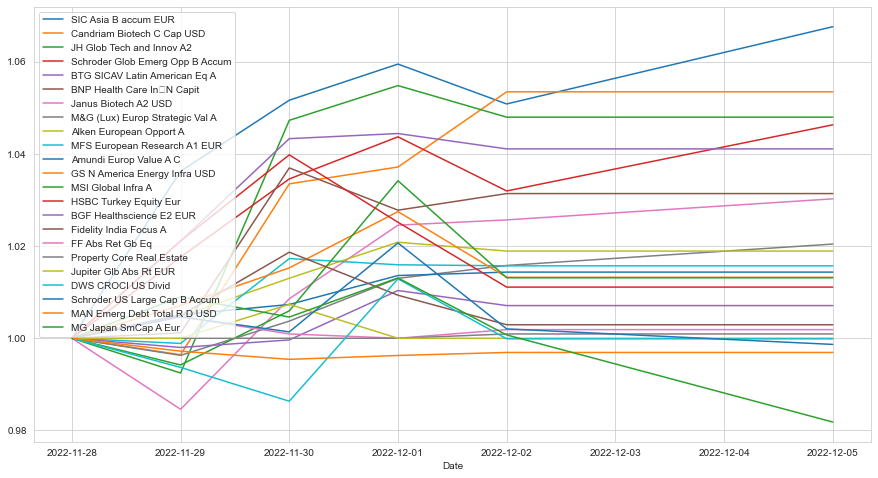

In [63]:
#df_portofolio_tmp.sort_values(by=['Racio'],ascending=False).to_csv("portfolio_data.csv",sep=",")
print('Start Date:',df_all.index[start])
df_all_tmp = df_all.fillna(method='bfill').fillna(method='pad').apply(lambda x: x/x[start], axis=0)
df_all_tmp = df_all_tmp.sort_values(by=df_all_tmp.index[finish],axis=1,ascending=False).rename(columns=code2name_dict)
ax = df_all_tmp.iloc[finish:start+1].plot(figsize=(15,8),grid=True)
ax.legend(loc='upper left')
ax

In [52]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

if 'LU0122613903' in dict_df:
    del dict_df['LU0122613903']

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df = df_all #.dropna()

# print(df.index)

mu = mean_historical_return(df.sort_index())
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
df_mu = pd.DataFrame(data = {'Name':df_portofolio['Nome'],'all':list(mu)}, index=list(mu.keys()))
df_w = pd.DataFrame(data = {'Name':df_portofolio['Nome'] ,'all':list(cleaned_weights.values())}, index=list(cleaned_weights.keys()))
df_pp = pd.DataFrame(data = {'all':list(ef.portfolio_performance())}, index=list(['anual return','volatility','sharpe ratio']))
mu_coef = {'all':0.3,90:0.3,5:0.15,10:0.15,30:0.10}
mu_w = mu_coef['all']*mu
for n in mu_coef.keys()-['all']:
    mu = mean_historical_return(df[:n].sort_index())
    
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if n == 60:
        mu_w += 0.30*mu
    else:
        mu_w += 0.175*mu
    df_mu[n] = list(mu)
    df_w[n] = list(cleaned_weights.values())
    df_pp[n] = list(ef.portfolio_performance())
    

ef = EfficientFrontier(mu_w, S)
weights = ef.max_sharpe()

df_w['Avg'] = list(ef.clean_weights().values())
df_w['Now'] = df_portofolio_tmp['Amount EUR']/df_portofolio_tmp['Amount EUR'].sum()
df_pp['Avg'] = list(ef.portfolio_performance())
df_mu['Avg'] = list(mu_w)
df_mu.sort_values(by="Avg",ascending=False)

,Name,all,5,10,90,30,Avg
LU0108459040,Candriam Biotech C Cap USD,-0.012623,32.302524,2.769696,0.510876,1.422457e+00,6.472185
IE0002167009,JH Glob Tech and Innov A2,-0.372629,29.778812,1.683528,-0.210233,6.935164e-01,5.478695
LU1897414303,Janus Biotech A2 USD,0.020825,16.363935,4.621364,1.003386,1.274954e+00,4.077384
LU0269905138,Schroder Glob Emerg Opp B Accum,-0.239113,4.761617,2.549694,0.105787,3.327291e+00,1.808534
LU0248173006,SIC Asia B accum EUR,-0.099246,5.539344,2.067530,-0.131107,2.137378e+00,1.652527
LU1670707956,M&G (Lux) Europ Strategic Val A,-0.035977,3.519310,2.139544,0.221573,2.514468e+00,1.458313
LU0213962813,HSBC Turkey Equity Eur,0.777891,-0.462429,1.072372,4.106695,1.862611e+00,1.384736
LU0823417141,BNP Health Care In\tN Capit,0.080554,5.502972,1.122868,0.041898,3.820095e-01,1.257872
LU0384381660,MSI Global Infra A,-0.035494,2.276935,0.961892,-0.147771,1.890721e+00,0.861163
LU0815616999,BTG SICAV Latin American Eq A,0.064428,2.389578,1.336256,0.353037,1.289349e-01,0.755695


In [53]:
df_mu.sort_values(by="Avg",ascending=False).to_csv("mu.csv")

In [54]:
df_w.sort_values(by=['Avg',5,'all',10,30,90],ascending=False)

,Name,all,5,10,90,30,Avg,Now
IE00BD3B6K23,MAN Emerg Debt Total R D USD,0.13461,0.46363,0.32966,0.21374,0.29901,0.40305,0.015854
LU0108459040,Candriam Biotech C Cap USD,0.00000,0.35133,0.14035,0.04030,0.07205,0.29959,0.047127
LU2210151697,FF Abs Ret Gb Eq,0.16088,0.05955,0.04169,0.08042,0.05317,0.07083,0.047071
IE00BLP5S460,Jupiter Glb Abs Rt EUR,0.31461,0.02501,0.10478,0.24462,0.11231,0.05773,0.015688
LU1897414303,Janus Biotech A2 USD,0.00000,0.04239,0.17604,0.07145,0.00000,0.05484,0.015531
PTSQUGHM0007,Property Core Real Estate,0.21578,0.02215,0.01303,0.13527,0.03301,0.03633,0.220464
LU0248173006,SIC Asia B accum EUR,0.00000,0.02844,0.04796,0.00000,0.00000,0.03432,0.032433
LU1670707956,M&G (Lux) Europ Strategic Val A,0.00000,0.00000,0.08199,0.00000,0.07494,0.02513,0.078755
LU0213962813,HSBC Turkey Equity Eur,0.11757,0.00000,0.00000,0.21419,0.00420,0.01161,0.040519
LU0269905138,Schroder Glob Emerg Opp B Accum,0.00000,0.00000,0.06449,0.00000,0.31816,0.00657,0.058416


In [55]:
df_pp

,all,5,10,90,30,Avg
anual return,0.154807,12.347172,1.585943,1.013713,1.374905,2.262371
volatility,0.054481,0.080892,0.077662,0.084911,0.074612,0.072298
sharpe ratio,2.474381,152.390097,20.163692,11.702941,18.159293,31.015820


In [56]:
df_portofolio_tmp['Amount EUR']/df_portofolio_tmp['Amount EUR'].sum()

Code
IE0002167009    0.016046
IE00BD3B6K23    0.015854
IE00BLP5S460    0.015688
LU0094557526    0.054103
LU0108459040    0.047127
LU0171309270    0.044979
LU0197230542    0.015752
LU0213962813    0.040519
LU0248173006    0.032433
LU0248185513    0.018513
LU0269905138    0.058416
LU0384381660    0.057945
LU0524465977    0.015946
LU0815616999    0.014533
LU0823417141    0.043101
LU1046545411    0.047617
LU1670707956    0.078755
LU1670715975    0.047240
LU1769942746    0.044473
LU1883314244    0.007895
LU1897414303    0.015531
LU2210151697    0.047071
PTSQUGHM0007    0.220464
Name: Amount EUR, dtype: float64